In [1]:
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import pyod
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import preprocessing
from pyod.utils.data import evaluate_print

from pyod.models.pca import PCA
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM

from pyod.models.lof import LOF 
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD

from pyod.models.abod import ABOD
from pyod.models.sos import SOS

from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lscp import LSCP

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL

from sklearn.preprocessing import StandardScaler
from feature_selector import FeatureSelector

np.set_printoptions(precision=3)

Using TensorFlow backend.
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\andre\Anaconda3\envs\security

In [3]:
testing_set = pd.read_csv('../Unbalanced_Samples/Sample_60K.csv',sep=',',header=0)

import csv
with open('../Unbalanced_Samples/Sample_60K.csv', newline='') as f:
  csv_reader = csv.reader(f)
  header = next(csv_reader)

for i in range(len(header)):
    header[i] = header[i]+" ("+str(i)+")"
print(header)

['Unnamed: 0 (0)', 'Flow ID (1)', 'Src IP (2)', 'Src Port (3)', 'Dst IP (4)', 'Dst Port (5)', 'Protocol (6)', 'Timestamp (7)', 'Flow Duration (8)', 'Tot Fwd Pkts (9)', 'Tot Bwd Pkts (10)', 'TotLen Fwd Pkts (11)', 'TotLen Bwd Pkts (12)', 'Fwd Pkt Len Max (13)', 'Fwd Pkt Len Min (14)', 'Fwd Pkt Len Mean (15)', 'Fwd Pkt Len Std (16)', 'Bwd Pkt Len Max (17)', 'Bwd Pkt Len Min (18)', 'Bwd Pkt Len Mean (19)', 'Bwd Pkt Len Std (20)', 'Flow Byts/s (21)', 'Flow Pkts/s (22)', 'Flow IAT Mean (23)', 'Flow IAT Std (24)', 'Flow IAT Max (25)', 'Flow IAT Min (26)', 'Fwd IAT Tot (27)', 'Fwd IAT Mean (28)', 'Fwd IAT Std (29)', 'Fwd IAT Max (30)', 'Fwd IAT Min (31)', 'Bwd IAT Tot (32)', 'Bwd IAT Mean (33)', 'Bwd IAT Std (34)', 'Bwd IAT Max (35)', 'Bwd IAT Min (36)', 'Fwd PSH Flags (37)', 'Bwd PSH Flags (38)', 'Fwd URG Flags (39)', 'Bwd URG Flags (40)', 'Fwd Header Len (41)', 'Bwd Header Len (42)', 'Fwd Pkts/s (43)', 'Bwd Pkts/s (44)', 'Pkt Len Min (45)', 'Pkt Len Max (46)', 'Pkt Len Mean (47)', 'Pkt Len 

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#transforma dados categóricos em números
for f in testing_set.columns: 
    if testing_set[f].dtype=='object': 
        label = preprocessing.LabelEncoder() 
        label.fit(list(testing_set[f].values)) 
        testing_set[f] = label.transform(list(testing_set[f].values))
    
testingSet = testing_set.values
np.random.shuffle(testingSet)

testingSet = testingSet.astype(float)

for i in range (6*10**4-1, 0, -1):
    for j in range(0, 6):
        testingSet[i, j] = float(testingSet[i, j])
        if (np.isinf(testingSet[i, j]) or np.isnan(testingSet[i, j])):
            testingSet = np.delete(testingSet, i, axis=0)

y_test = testingSet[:, 84].astype(int)

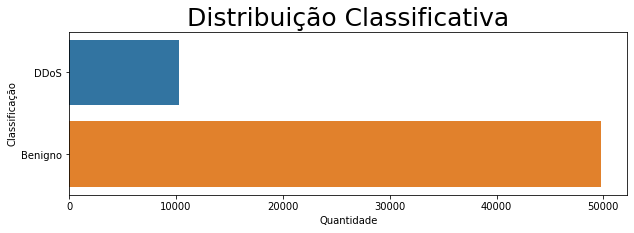

In [5]:
pyplot.subplots(figsize=(10, 3))
distribution = pd.DataFrame({"Classificação": ["DDoS","Benigno"],
                             "Quantidade":  [y_test.sum() , y_test.size - y_test.sum()]})
sns.barplot(data=distribution, y="Classificação", x="Quantidade").set_title("Distribuição Classificativa", fontsize=25)
pyplot.show()

In [6]:
#salva os sets originais
original_testingSet = testingSet
original_testingSet = np.delete(original_testingSet, 84, axis=1)
original_header = header
original_header = np.delete(original_header, 84, axis=0)

In [7]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index

In [8]:
#Features codificadas pelo label enconder: 17 16 7 4 2 1 0
#Feaatures sempre 0: 67, 66, 65, 64, 63, 62, 40, 39
#features com correlação próxima de zero, vide loop abaixo: 73, 71, 70, 50, 42, 34, 12, 10 

droppingList = [67, 66, 65, 64, 63, 62, 40, 39]
droppedFeatures = droppingList

cm = testing_set[top_corr_features].corr().values
for i in (droppingList):
    testingSet = np.delete(testingSet, i, axis=1)
    header = np.delete(header, i, axis=0)
    
    cm = np.delete(cm, i, axis = 0)
    cm = np.delete(cm, i, axis = 1)

tolerance = 0.4
for i in range(cm.shape[0]-1, 0, -1):
    if cm[cm.shape[0]-1, i] >= -tolerance and cm[cm.shape[0]-1, i] <= tolerance:
        if i not in droppingList:
            droppedFeatures.append(i)
            testingSet = np.delete(testingSet, i, axis=1)
            header = np.delete(header, i, axis=0)
print("Features dropadas: ")
print(droppedFeatures)

Features dropadas: 
[67, 66, 65, 64, 63, 62, 40, 39, 75, 74, 73, 72, 71, 70, 69, 68, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]


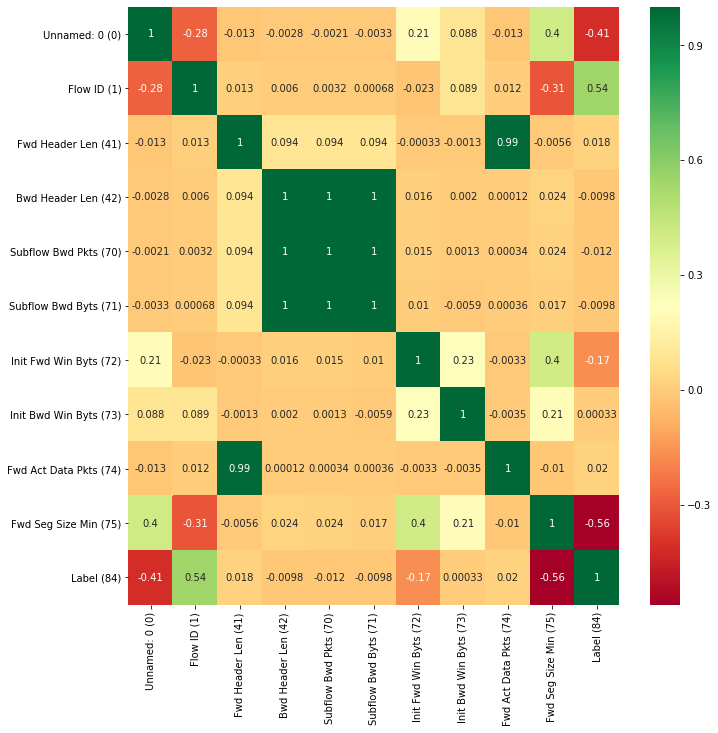

In [9]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
corrmat = testing_set.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(testingSet.shape[1], testingSet.shape[1]))
#plot heat map
g=sns.heatmap(testing_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g.set_ylim(g.get_ylim()[0]+0.5, g.get_ylim()[1]-0.5)

testingSet = np.delete(testingSet, 84-len(droppedFeatures), axis=1)  #deleta o label
header = np.delete(header, 84-len(droppedFeatures), axis=0)

labelCorrelation_testingSet = testingSet
labelCorrelation_header = header

In [10]:
testing_set = pd.DataFrame(testingSet)
testing_set.columns = header
fs = FeatureSelector(data = testing_set, labels = y_test)
fs.identify_collinear(correlation_threshold = 0.85)

#gets real indexes of collinear above threshold features
real_indexs = np.zeros(fs.record_collinear.shape[0])
j = 0
for i in range(header.size):
    if (header[i] == fs.record_collinear.iloc[j, 0]):
        real_indexs[j] = i
        j = j+1

real_indexs = np.unique(real_indexs)
for i in range(real_indexs.size - 1, -1, -1):
    np.delete(testingSet, real_indexs[i], axis = 1)

print(real_indexs)
fs.record_collinear.head()

3 features with a correlation magnitude greater than 0.85.

[0. 4. 5.]


C:\Users\andre\Anaconda3\envs\security\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


,drop_feature,corr_feature,corr_value
0,Subflow Bwd Pkts (70),Bwd Header Len (42),0.999087
1,Subflow Bwd Byts (71),Bwd Header Len (42),0.998389
2,Subflow Bwd Byts (71),Subflow Bwd Pkts (70),0.999059
3,Fwd Act Data Pkts (74),Fwd Header Len (41),0.993451


In [11]:
#Aplica a padronização z-score
"""testingSetSaved = testingSet

mi = np.mean(testingSet)
sigma = np.std(testingSet)
testingSet = (testingSet - mi) / sigma"""

#Aplica regularização default sk-learn
scaler = StandardScaler()
scaler.fit_transform(testingSet)

array([[ 0.142, -0.862, -0.02 , ..., -0.471, -0.011, -0.52 ],
       [ 0.976,  1.277, -0.018, ..., -0.459, -0.011,  0.888],
       [ 0.515,  0.636, -0.014, ..., -0.471, -0.01 ,  0.888],
       ...,
       [ 0.968,  0.925, -0.014, ..., -0.471, -0.01 ,  0.888],
       [-0.06 ,  0.21 , -0.018, ..., -0.471, -0.011,  0.888],
       [-1.284,  1.026, -0.017, ..., -0.461, -0.011, -1.46 ]])

In [12]:
outliers_fraction = 0.17
def testMethod(clf, clf_name):
    clf.fit(testingSet)

    #####################################################################

    y_test_pred = clf.predict(testingSet)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(testingSet)  # outlier scores

    #####################################################################

    print("\nOn Test Data - "+clf_name+":")
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0

    for i in range(y_test.size):
        if(y_test[i] == 1 and y_test_pred[i] == 1):
            truePositive = truePositive+1
        elif (y_test[i] == 0 and y_test_pred[i] == 0):
            trueNegative = trueNegative+1
        elif (y_test[i] == 0 and y_test_pred[i] == 1):
            falsePositive = falsePositive+1
        else:
            falseNegative = falseNegative+1

    print(truePositive, " | ", falsePositive)
    print(falseNegative, " | ", trueNegative,"\n")

    evaluate_print(clf_name, y_test, y_test_scores)

    #####################################################################

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_scores)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic - '+clf_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    #gets usual metrics based on results obtained
    total = y_test.shape[0]
    
    accuracy = (truePositive+trueNegative)/total
    print("Accuracy: ", accuracy)
    
    if(truePositive+falsePositive != 0):
        precision = truePositive/(truePositive+falsePositive)
        print("Precision: ", precision)
    else:
        precision = 0
        print("Precision: -")
        
    if(truePositive+falseNegative != 0):
        recall = truePositive/(truePositive+falseNegative)
        print("Recall: ", recall)
    else:
        recall = 0
        print("Recall: -")
        
    if(recall + precision != 0):
        f1 = 2*(recall*precision)/(recall+precision)
        print("F1-score: ", f1)
    else:
        print("F1-score: -")
        
    print("\n")


On Test Data - PCA:
511  |  9689
9745  |  40055 

PCA ROC:0.6951, precision @ rank n:0.051


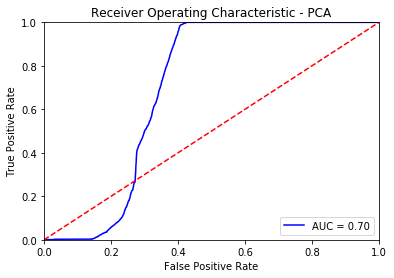

Accuracy:  0.6761
Precision:  0.05009803921568627
Recall:  0.049824492979719186
F1-score:  0.04996089166992569




C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.788648519976576 > 84.208169299049715). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.711629293498618 > 84.569019121022734). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.802823245802983 > 84.667727127117715). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.178458137238565 > 90.947894089938245). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.790563508528933 > 93.472065838814316). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.025713020440492 > 92.778263532895693). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.235599325350478 > 90.991790159675830). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.861669876592202 > 84.709551556239290). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.876124284077747 > 84.714235254055836). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.705362873733847 > 84.645480194381676). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (85.403781431706705 > 85.074158966459635). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.785064838209834 > 84.325667963249344). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.517217290746984 > 91.217689756874506). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.784404795390287 > 91.601914120930132). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.039240549943543 > 92.989563472028593). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.811260479900753 > 91.642632676415104). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.243161916992904 > 91.020709041482249). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.232012093819122 > 92.979423864418905). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.200469058619063 > 90.941577101481059). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.244658760430852 > 91.002382619102207). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.963963049313975 > 90.865130958547041). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.908380302207874 > 90.579810257866100). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.046984002665994 > 90.956848595841691). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.947441109908652 > 90.546140726793467). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.802859209973633 > 84.718612976414732). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.202350255838255 > 93.082016783593872). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.896824409369799 > 90.659542855670438). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.247835877770953 > 90.952968326273336). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.255761742411849 > 90.947965325244326). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.242591859027073 > 90.956940547191053). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (89.265718609832504 > 88.895162157160868). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.234834552292227 > 90.939225357954740). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.716694727402569 > 84.565048670323833). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.808751148899162 > 84.674379693301404). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (89.268992516787492 > 88.951607737976488). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.853229922568261 > 84.269920878567120). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.716090068688516 > 84.626078892871547). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.789263075395397 > 84.347149237622034). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.986859028694610 > 90.409074036429175). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.242591859027073 > 90.922326508435134). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.229250024531865 > 90.929797407817532). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.231190457626042 > 90.941112590425192). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.716694727402569 > 84.577391305014800). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.245742939742058 > 90.884930721159066). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.245742939742058 > 90.907348991859649). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.242591859027073 > 90.861950111048642). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.923394176601647 > 90.703666894985545). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.954336294542287 > 90.876011549599639). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.849314533329562 > 84.342346416211200). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.707378948683157 > 84.665941447306579). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.866782637903640 > 84.809267991858150). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.875050843255536 > 84.713971900542418). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.619675342777867 > 90.348722576034945). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.271875174673511 > 90.983616382357908). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (96.639722611463753 > 96.290325724041836). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.710807001848522 > 84.629923170174592). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.474905728086469 > 92.982267721450526). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.199602583279429 > 91.069506431270312). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.190357345264033 > 91.049422773363219). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.237166881516657 > 91.035605845609524). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.907548395486202 > 90.663176268143843). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.923394176601647 > 90.682095348972013). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (90.998506411226415 > 90.744750966283519). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.251680019489896 > 91.021101198351460). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.205135462044481 > 91.032102581715904). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.218516884159428 > 90.972207756307256). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.657743130842533 > 93.591007168915283). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (92.597956415415126 > 92.268132637644911). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (94.666792183162912 > 94.046065963796707). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.234945752766706 > 90.926496742702099). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (93.008682937557282 > 92.667884415111331). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.231779250636706 > 90.938250549713644). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (94.431018302169960 > 94.118206639003787). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (94.146279993357339 > 93.733839505481029). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (94.125482379005945 > 93.547736433792849). You may want to try with a higher value of support_fraction (current valu

C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (91.234430296926064 > 91.217241737211651). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.991602078272706 > 84.827070186346802). You may want to try with a higher value of support_fraction (current value: 0.501).
  RuntimeWarning)
C:\Users\andre\Anaconda3\envs\security\lib\site-packages\sklearn\covariance\robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.711629293498618 > 84.626247903529944). You may want to try with a higher value of support_fraction (current valu


On Test Data - MCD:
2422  |  7778
7834  |  41966 

MCD ROC:0.6283, precision @ rank n:0.2416


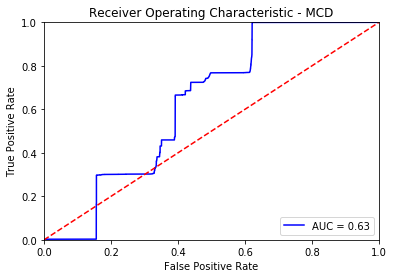

Accuracy:  0.7398
Precision:  0.23745098039215687
Recall:  0.23615444617784712
F1-score:  0.2368009385999218



On Test Data - OCSVM:
3  |  11
10253  |  49733 

OCSVM ROC:0.4962, precision @ rank n:0.2143


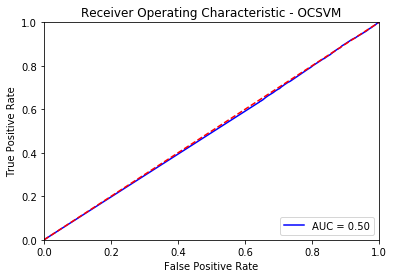

Accuracy:  0.8289333333333333
Precision:  0.21428571428571427
Recall:  0.00029251170046801873
F1-score:  0.000584225900681597




In [13]:
#Linear Models
classifiers = {
    'PCA': PCA(contamination= outliers_fraction),
    'MCD': MCD(contamination= outliers_fraction),
    'OCSVM': OCSVM(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)


On Test Data - LOF:
253  |  9139
10003  |  40605 

LOF ROC:0.4114, precision @ rank n:0.029


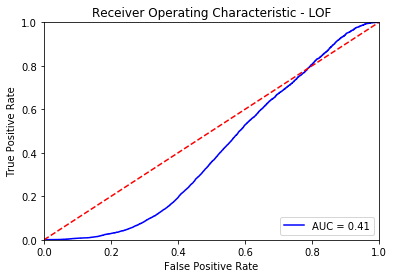

Accuracy:  0.6809666666666667
Precision:  0.026937819420783646
Recall:  0.02466848673946958
F1-score:  0.02575325732899023



On Test Data - CBLOF:
955  |  9245
9301  |  40499 

CBLOF ROC:0.452, precision @ rank n:0.0943


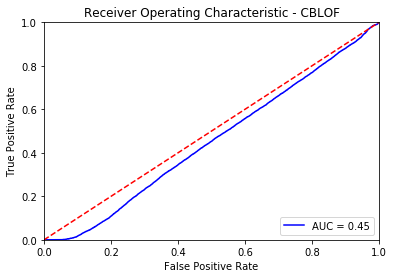

Accuracy:  0.6909
Precision:  0.09362745098039216
Recall:  0.09311622464898596
F1-score:  0.09337113805240517



On Test Data - HBOS:
4601  |  4719
5655  |  45025 

HBOS ROC:0.8573, precision @ rank n:0.4937


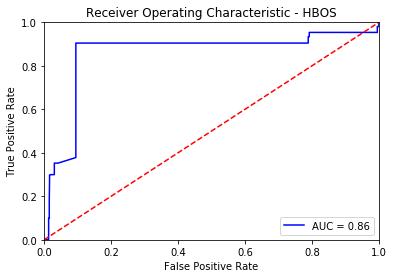

Accuracy:  0.8271
Precision:  0.4936695278969957
Recall:  0.4486154446177847
F1-score:  0.4700653861871679



On Test Data - kNN:
104  |  8492
10152  |  41252 

kNN ROC:0.5066, precision @ rank n:0.0206


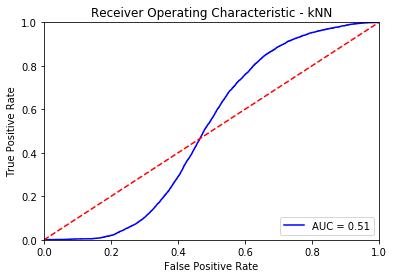

Accuracy:  0.6892666666666667
Precision:  0.01209865053513262
Recall:  0.01014040561622465
F1-score:  0.01103331211542542



On Test Data - AvgKNN:
84  |  7287
10172  |  42457 

AvgKNN ROC:0.5103, precision @ rank n:0.0239


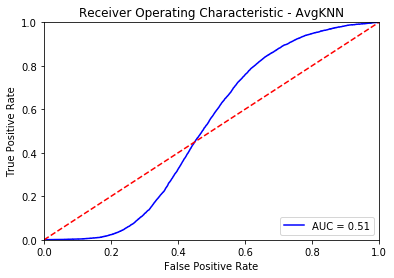

Accuracy:  0.7090166666666666
Precision:  0.011396011396011397
Recall:  0.008190327613104524
F1-score:  0.009530833380609293



On Test Data - MedKNN:
148  |  7527
10108  |  42217 

MedKNN ROC:0.5116, precision @ rank n:0.0369


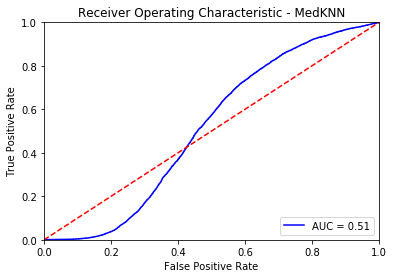

Accuracy:  0.7060833333333333
Precision:  0.019283387622149838
Recall:  0.014430577223088924
F1-score:  0.01650772405331549



On Test Data - SOD:
479  |  9721
9777  |  40023 

SOD ROC:0.2537, precision @ rank n:0.0472


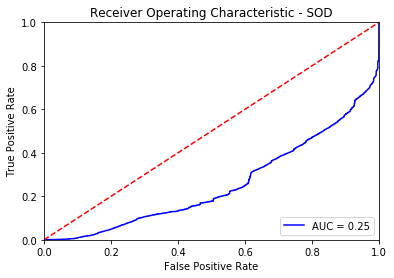

Accuracy:  0.6750333333333334
Precision:  0.04696078431372549
Recall:  0.046704368174726986
F1-score:  0.046832225263981224




In [14]:
#Proximity Based
classifiers = {
    #'COF': COF(contamination= outliers_fraction),  #Apresentou erros de execução.
    'LOF': LOF(contamination = outliers_fraction),
    'CBLOF':CBLOF(contamination= outliers_fraction),
    #'LOCI':LOCI(contamination= outliers_fraction),   #Travou a máquina de execução repetidas vezes.
    'HBOS': HBOS(contamination= outliers_fraction),
    'kNN': KNN(method='largest', contamination= outliers_fraction),
    'AvgKNN': KNN(method='mean', contamination= outliers_fraction),
    'MedKNN': KNN(method='median', contamination= outliers_fraction),
    'SOD': SOD(contamination= outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)    


On Test Data - ABOD:
509  |  9660
9747  |  40084 

ABOD ROC:0.5066, precision @ rank n:0.0506


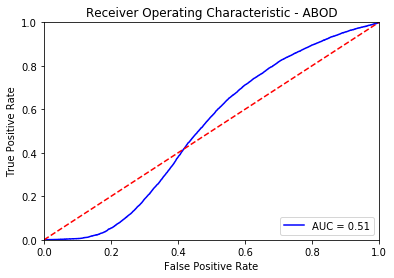

Accuracy:  0.67655
Precision:  0.05005408594748746
Recall:  0.04962948517940718
F1-score:  0.04984088127294982




MemoryError: Unable to allocate array with shape (60000, 60000) and data type float64

In [15]:
#Probabilistic tests
classifiers = {
    'ABOD': ABOD(contamination = outliers_fraction),
    #'SOS': SOS(contamination = outliers_fraction) #Apresentou erros de execução.
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)

In [ ]:
#Ensenbles tests
listDetectors = detector_list=[HBOS(),
                               PCA(),
                               ABOD(),
                               LOF(),
                               KNN()]
classifiers = {
    'Isolation Forest': IForest(contamination = outliers_fraction),
    'Feature Bagging': FeatureBagging(contamination = outliers_fraction)
    #'LSCP': LSCP(detector_list = listDetectors, contamination = outliers_fraction) #Still couldn't get it to work
    #XGBOD tests are in a separate file
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)

In [ ]:
#Neural Networks tests
classifiers = {
    'AutoEncoder': AutoEncoder(contamination = outliers_fraction, hidden_neurons = [8, 4, 4, 8], epochs = 15),
    'SO_GAAL': SO_GAAL(contamination = outliers_fraction),
    'MO_GAAL': MO_GAAL(contamination = outliers_fraction)
}

for i, (clf_name, clf) in enumerate(classifiers.items()):
    testMethod(clf, clf_name)